In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import sampler,DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [4]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [5]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [6]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

In [7]:
NUM_TRAIN = 49000
NUM_VAL = 1000

loader_train = DataLoader(trainset, batch_size=16,num_workers=4,sampler=ChunkSampler(NUM_TRAIN, 0))

loader_val = DataLoader(trainset, batch_size=16,num_workers=4,sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

In [8]:
loader_test = DataLoader(testset, batch_size=16, shuffle=True,num_workers=4)

In [10]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ##########################################################################################
    #   Il faut transposée les images car PyTorch lis les image en [Chanels, Width, Height]  #
    #   et pour les voir il faut qu'elles soient [Width, Height, Chanels]                    #
    ##########################################################################################
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

In [12]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

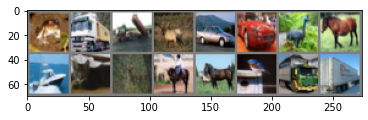

 frog truck truck  deer   car   car  bird horse  ship   cat  deer horse horse  bird truck truck


In [13]:
# get some random training images
dataiter = iter(loader_train)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

In [29]:
res_mod = models.resnet34(pretrained=True)

In [30]:
print(res_mod)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, len(classes))

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
res_mod = res_mod.to(device)